# Figure 1 - trends
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from scipy import stats

Data location

In [2]:
loc_panel = "../Data/Panel/"

Years

In [3]:
y1_panel = 1954
y2_panel = 2019

#### Analysis/plotting

Read panel

In [4]:
data = pd.read_csv(loc_panel+"baseball_climate_data_"+str(y1_panel)+"-"+str(y2_panel)+".csv")
y1_final = 1962
data = data.loc[data.year>=y1_final,:]
data["total_hr"] = data["visitor_hr"] + data["home_hr"]
data["tx"] = data["tmax_hadisd"]*1.0
data["rh"] = data["rh_hadisd"]*1.0

Calculate density

In [5]:
pv = data["vapor_pressure_hadisd"].values*100.0 # hPa to Pa
pd = data["slp_hadisd"].values*100.0 - pv
rd = 287.058
rv = 461.495
tk = data["tmean_hadisd"].values + 273.15
data["density"] = (pd/(rd*tk)) + (pv/(rv*tk))

Total home runs and home runs in selected parks

In [6]:
hr_sum = data.groupby("year").sum().reset_index().loc[:,["year","total_hr","visitor_hr","home_hr"]]
hr_mean = data.groupby("year").mean().reset_index().loc[:,["year","total_hr","visitor_hr","home_hr","tx","density"]]
hr_mean["tx_f"] = (hr_mean.tx.values * (9.0/5)) + 32

In [7]:
hr_parklevel = data.groupby(["park_id","year"]).mean().reset_index().loc[:,["year","park_id","total_hr","tx"]]

Fig

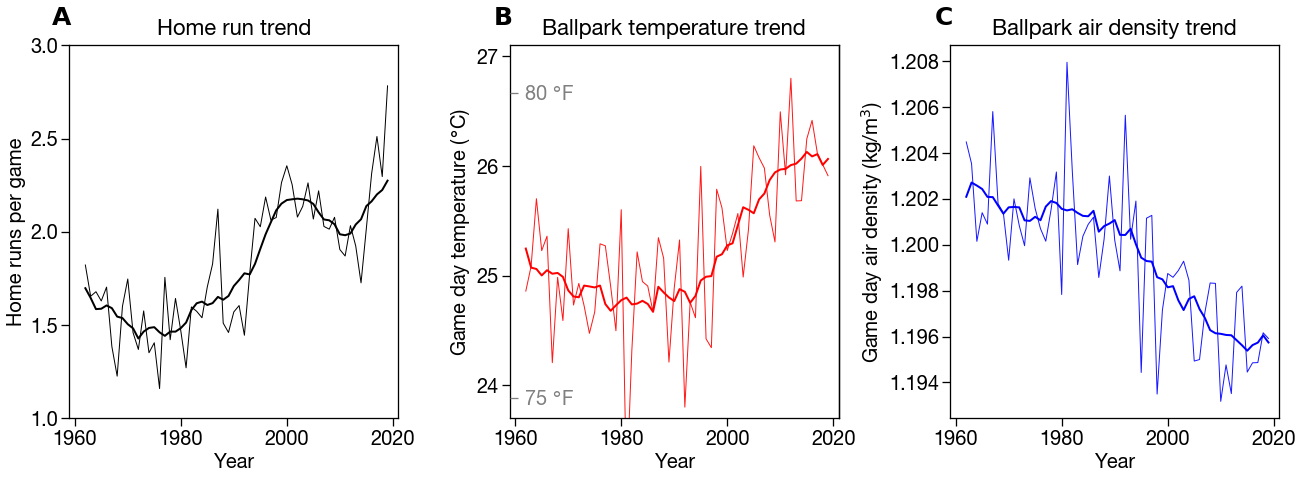

In [9]:
fig = plt.figure(figsize=(21,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.1,right=0.9,top=0.88,bottom=0.14,wspace=0.34,hspace=0.3)
b = 0.14
w = 0.21
h = 0.74


tfs = 22

ax = plt.subplot(gs1[0,0])
#ax = fig.add_axes([0.1,b,w,h])

plt.plot(hr_mean.year.values,hr_mean.total_hr.values,
         color="black",linewidth=1,zorder=3)
hr_rolling = hr_mean.total_hr.rolling(10,center=True,min_periods=1).mean()
plt.plot(hr_mean.year.values,hr_rolling.values,
         color="black",linewidth=2,zorder=4)



plt.xlim([1959,2021])
plt.xlabel("Year")
plt.ylabel("Home runs per game")
#plt.yticks([23,24,25,26,27])
plt.title("Home run trend",fontsize=tfs,pad=10)
plt.ylim([1,3])
plt.yticks([1,1.5,2.0,2.5,3])


ax = plt.subplot(gs1[0,1])
#ax = fig.add_axes([0.37,b,w,h])
#ax.spines['right'].set_visible(False)

plt.plot(hr_mean.year.values,hr_mean.tx.values,
         color="red",linewidth=1,zorder=1,alpha=0.9)
tx_rolling = hr_mean.tx.rolling(10,center=True,min_periods=1).mean()
plt.plot(hr_mean.year.values,tx_rolling.values,
         color="red",linewidth=2,zorder=4)

plt.xlim([1959,2021])
ylimb = [23.7,27.1]
plt.ylim(ylimb)
plt.xlabel("Year")
plt.title("Ballpark temperature trend",fontsize=tfs,pad=10)
plt.ylabel("Game day temperature ($\degree$C)")
#plt.ylabel("Temperature relative to "+str(y1_clm_fig1)+"-"+str(y2_clm_fig1-1900)+" ($\degree$C)")
plt.yticks([24,25,26,27])


## other axis
ax2 = ax.twinx()
ax2.yaxis.tick_left()
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(True)
#ax2.spines["left"].set_position(("axes", -0.24))
ax2_vals = [75,80] #np.arange(75,80+1,1)
#ax2_locs = [(x*(9.0/5) + 32) for x in ax2_cvals]
ax2_locs = [(x-32)*(5.0/9) for x in ax2_vals]
ax2.set_yticks(ticks=ax2_locs)
ax2.set_yticklabels(labels=[str(x)+" $\degree$F" for x in ax2_vals])
ax2.set_ylim(ylimb)
ax2.tick_params(axis="y",direction="in",pad=-65,colors="gray")
#ax2.yaxis.label.set_color('gray')
#ax2.set_ylabel("Game day temperature ($\degree$C)",labelpad=-453)
#ax2.set_ylabel("Game day temperature ($\degree$F)",labelpad=30,rotation=270)



ax = plt.subplot(gs1[0,2])
#ax = fig.add_axes([0.7,b,w,h])

plt.plot(hr_mean.year.values,hr_mean.density.values,
         color="blue",linewidth=1,zorder=1,alpha=0.9)
dens_rolling = hr_mean.density.rolling(10,center=True,min_periods=1).mean()

plt.plot(hr_mean.year.values,dens_rolling.values,
         color="blue",linewidth=2,zorder=4)

plt.xlim([1959,2021])
#plt.ylim([-1.1,2.1])
plt.xlabel("Year")

#plt.ylabel("Air density relative to "+str(y1_clm_fig1)+"-"+str(y2_clm_fig1-1900)+" (%)")
plt.ylabel("Game day air density (kg/m$^3$)")
plt.title("Ballpark air density trend",fontsize=tfs,pad=10)


plt.figtext(0.088,0.92,r'$\bf{A}$',fontsize=25)
plt.figtext(0.38,0.92,r'$\bf{B}$',fontsize=25)
plt.figtext(0.672,0.92,r'$\bf{C}$',fontsize=25)


plt.savefig("../Figures/Fig1.pdf")
plt.show()